# Translation from One Language to Another

This model will appear on my HuggingFace profile as: 'mbart-large-50-English_German_Translation'
    
Dataset Source: https://www.kaggle.com/datasets/hgultekin/paralel-translation-corpus-in-22-languages

#### Import Necessary Libraries

In [1]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import transformers
from transformers import DataCollatorForSeq2Seq, MBart50Tokenizer, AutoModelForSeq2SeqLM
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, set_seed

import datasets
from datasets import Dataset, DatasetDict

import evaluate

#### Versions of Software & Libraries Used

In [2]:
print("Transformers:".ljust(15), transformers.__version__)
print("Pandas:".ljust(15), pd.__version__)
print("NumPy:".ljust(15), np.__version__)
print("Python:".ljust(15), sys.version[0:6]) 
print("Datasets:".ljust(15), datasets.__version__)

Transformers:   4.22.2
Pandas:         1.5.0
NumPy:          1.23.3
Python:         3.9.12
Datasets:       2.5.2


#### Ingest & Start Preprocessing Data

In [3]:
data = pd.read_csv('~/Documents/nlpnn/Datasets/Parallel Translation Corpus in 24 Languages/EN-DE (German)/EN-DE.txt', 
                   delimiter='\t', 
                   engine="c", 
                   header=None)

data.drop_duplicates(inplace=True)

data.dropna(inplace=True)

data[0] = data[0].str.strip()
data[1] = data[1].str.strip()

data.drop(columns=[2, 3, 4, 5, 6, 7], inplace=True)

data.rename(columns={1 : 'german', 0 : 'english'}, inplace=True)

data

,english,german
0,Commission Regulation (EC) No 1788/2004,Verordnung (EG) Nr. 1788/2004 der Kommission
1,of 15 October 2004,vom 15. Oktober 2004
2,fixing the minimum selling prices for butter f...,zur Festsetzung der Mindestverkaufspreise für ...
3,"THE COMMISSION OF THE EUROPEAN COMMUNITIES,",DIE KOMMISSION DER EUROPÄISCHEN GEMEINSCHAFTEN —
4,Having regard to the Treaty establishing the E...,gestützt auf den Vertrag zur Gründung der Euro...
...,...,...
5693619,Third country code [1],Drittland-Code [1]
5693620,Standard import value,Pauschaler Einfuhrpreis
5693621,Country nomenclature as fixed by Commission Re...,Nomenklatur der Länder gemäß der Verordnung (E...
5693622,Code ‘999’ stands for ‘of other origin’.,Der Code „999“ steht für „Verschiedenes“.


#### Visual: Length of English Entries

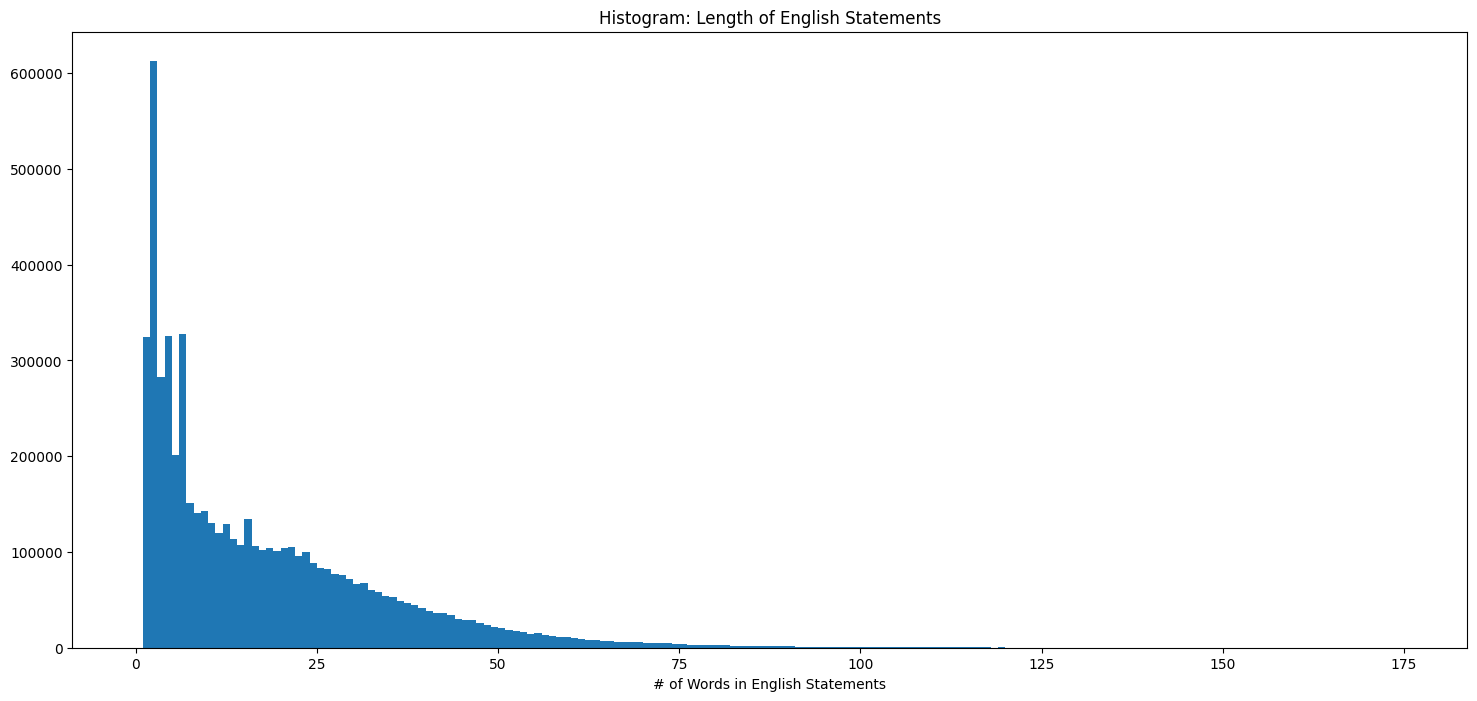

326


In [4]:
data['english_length'] = data['english'].str.split().str.len()

n_bin = 175
data.hist('english_length', grid=False, figsize=(18,8), range=(0,n_bin), bins=n_bin)
plt.title('Histogram: Length of English Statements')
plt.xlabel('# of Words in English Statements')
plt.show()

print(max(data['english_length']))

#### Visual: Length of French Entries

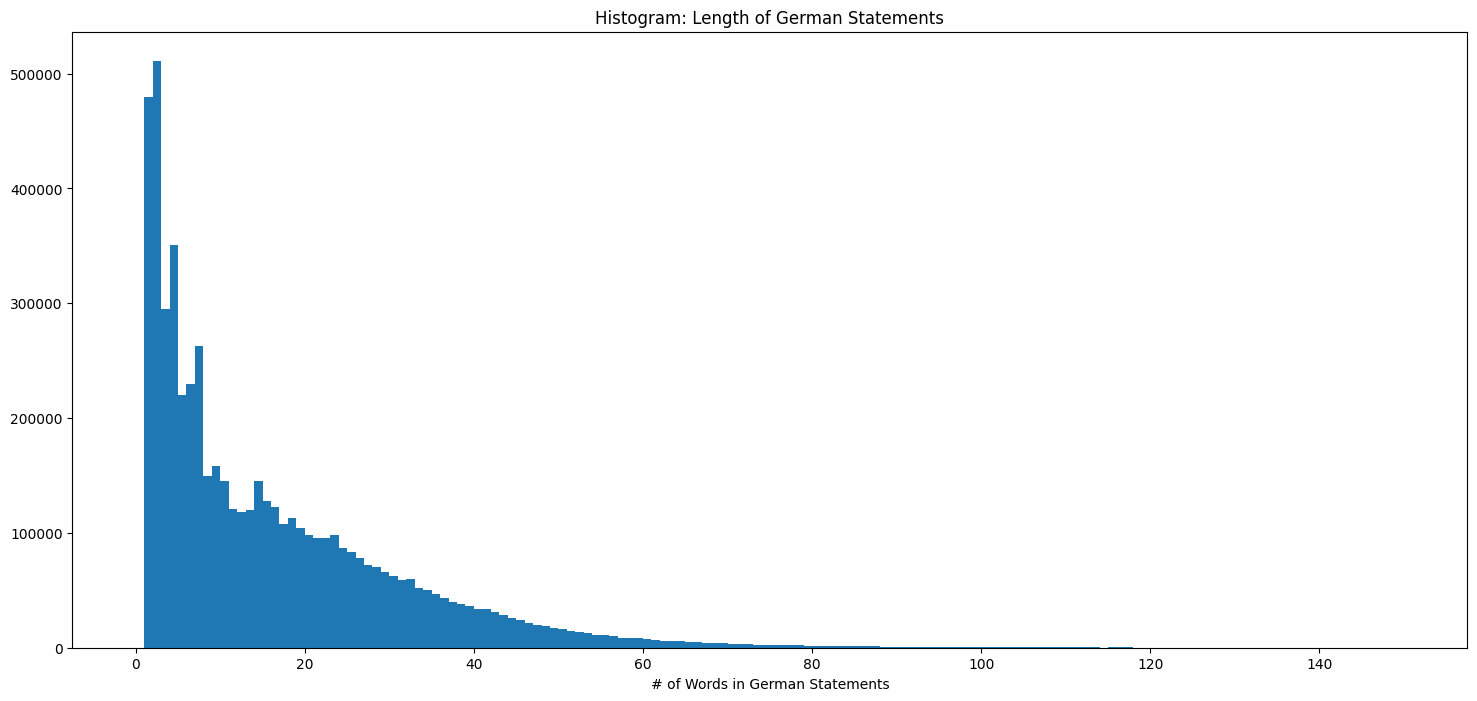

357


In [5]:
data['german_length'] = data['german'].str.split().str.len()

n_bin=150
data.hist('german_length', grid=False, figsize=(18,8), range=(0,n_bin), bins=n_bin)
plt.title('Histogram: Length of German Statements')
plt.xlabel('# of Words in German Statements')
plt.show()

print(max(data['german_length']))

#### Trim Dataset Size & Drop Unnecessary Features

In [6]:
upper_limit = 46
lower_limit = 5

data = data[data['german_length'] < upper_limit]
data = data[data['german_length'] > lower_limit]

data = data[data['english_length'] < upper_limit]
data = data[data['english_length'] > lower_limit]

data['eng_char_length'] = data['english'].str.len()
data['german_char_length'] = data['german'].str.len()

data = data[data['eng_char_length'] > 30]
data = data[data['german_char_length'] > 30]

data.reset_index(drop=True, inplace=True)

data.drop(columns=['german_length', 'english_length', 'eng_char_length', 'german_char_length'], inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3201470 entries, 0 to 3201469
Data columns (total 2 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   english  object
 1   german   object
dtypes: object(2)
memory usage: 48.9+ MB


#### Randomly Sample 36,000 Samples (Due to Hardware Limitations)

In [7]:
data = data.sample(n=36000, random_state=42, ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   english  36000 non-null  object
 1   german   36000 non-null  object
dtypes: object(2)
memory usage: 562.6+ KB


#### Final Preprocessing

In [8]:
data.rename(columns={'english' : 'en', 'german' : 'de'}, inplace=True)

all_data = data.to_dict(orient='records')
df = pd.Series(all_data)
df = pd.DataFrame(df)
df.rename(columns={ 0 : 'translation'}, inplace=True)
df.head()

,translation
0,{'en': 'When signs of severe fighting appear t...
1,{'en': 'amending Regulation (EEC) No 3703/85 l...
2,"{'en': 'Machaya, Jason (a.k.a. Jaison) Max Kok..."
3,{'en': 'The ESS ERIC shall subscribe to the De...
4,{'en': 'This Decision shall be published in th...


#### Convert to Dataset Format & Split into Train/Test/Eval Datasets

In [9]:
dataset = Dataset.from_pandas(df)

train_testEval = dataset.train_test_split(train_size=0.80)
test_eval = train_testEval['test'].train_test_split(train_size=0.50)

ds = DatasetDict({
    'train' : train_testEval['train'],
    'test' : test_eval['train'],
    'eval' : test_eval['test'],
})

print("Training Dataset Shape:", ds['train'].shape)
print("Testing Dataset Shape:", ds['test'].shape)
print("Evaluation Dataset Shape:", ds['eval'].shape)
ds['train'][275]

Training Dataset Shape: (28800, 1)
Testing Dataset Shape: (3600, 1)
Evaluation Dataset Shape: (3600, 1)


{'translation': {'de': 'Der einheitliche Begleitschein im Anhang ist für alle Verbringungen radioaktiver Abfälle und abgebrannter Brennelemente zwischen den Mitgliedstaaten, in die Gemeinschaft und aus der Gemeinschaft sowie für die Durchfuhr durch die Gemeinschaft im Rahmen des Anwendungsbereichs der Richtlinie 2006/117/Euratom zu verwenden.',
  'en': 'The standard document set out in the Annex shall be used in respect of any shipments of radioactive waste or spent fuel between Member States or into, out of and through the Community within the scope of Directive 2006/117/Euratom.'}}

#### Remember to Install git lfs & Enter HuggingFace Access Token

In [10]:
# Enter Huggingface Access Token

!git lfs install

Git LFS initialized.


#### Basic Values/Constants

In [11]:
num_of_epochs = 1
set_seed=42
BATCH_SIZE = 32
learning_rate = 2e-5
max_length = int(upper_limit*1.3)
source_language = "en"
target_language = "de"
device = "cpu"

model_ckpt = "facebook/mbart-large-50"

#### Create Tokenizer

In [12]:
tokenizer = MBart50Tokenizer.from_pretrained(model_ckpt, num_labels=2)

if "mbart" in model_ckpt:
    tokenizer.src_lang="en_XX"
    tokenizer.tgt_lang='de_DE'

#### Create Preprocessing Function

In [13]:
def tokenizing_function(examples):
    inputs = [ex[source_language] for ex in examples['translation']]
    targets = [ex[target_language] for ex in examples['translation']]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=max_length, truncation=True)
    return model_inputs

#### Apply Preprocessing Function to Dataset

In [14]:
encoded_ds = ds.map(tokenizing_function, batched=True, load_from_cache_file=False)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

#### Print Example to Make Sure Edits Work as Expected

In [15]:
print(encoded_ds['train'].shape)
print(encoded_ds['test'].shape)
print(encoded_ds['eval'].shape)

(28800, 4)
(3600, 4)
(3600, 4)


#### Instantiate Model

In [16]:
model = (AutoModelForSeq2SeqLM.from_pretrained(model_ckpt, num_labels=2)).to(device)

#### Instantiate Data Collator

In [17]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

#### Create Function to Compute Metrics

In [18]:
bleu_metric = evaluate.load("sacrebleu")
rouge_metric = evaluate.load("rouge")
meteor_metric = evaluate.load("meteor")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    
    if isinstance(preds, tuple):
        preds = preds[0]
    
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]
    
    bleu_results = bleu_metric.compute(predictions=decoded_preds, references=decoded_labels)
    rouge_results = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels)
    meteor_results = meteor_metric.compute(predictions=decoded_preds, references=decoded_labels)
    
    return {"bleu" : bleu_results["score"], "rouge" : rouge_results, "meteor" : meteor_results}

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/briandunn/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/briandunn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/briandunn/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


#### Instantiate Training Arguments

In [19]:
model_name = model_ckpt.split("/")[-1]
model_name = f"{model_name}-English_German_Translation"

args = Seq2SeqTrainingArguments(output_dir=model_name, 
                                per_device_train_batch_size=BATCH_SIZE, 
                                per_device_eval_batch_size=BATCH_SIZE,
                                evaluation_strategy="epoch", 
                                logging_strategy="epoch", 
                                learning_rate=learning_rate,
                                report_to='all', 
                                weight_decay=0.01, 
                                save_total_limit=2, 
                                disable_tqdm=False,
                                num_train_epochs=num_of_epochs, 
                                predict_with_generate=True,
                                push_to_hub=True)

#### Instantiate Trainer

In [20]:
trainer = Seq2SeqTrainer(model=model, 
                         args=args, 
                         train_dataset=encoded_ds['train'], 
                         eval_dataset=encoded_ds['eval'], 
                         tokenizer=tokenizer, 
                         data_collator=data_collator,
                         compute_metrics=compute_metrics)

/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/huggingface_hub/repository.py:705: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.11.
  warnings.warn(
Cloning https://huggingface.co/DunnBC22/mbart-large-50-English_German_Translation into local empty directory.


#### Train Model

In [21]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `MBartForConditionalGeneration.forward` and have been ignored: translation. If translation are not expected by `MBartForConditionalGeneration.forward`,  you can safely ignore this message.
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 28800
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 900


A Jupyter Widget

Saving model checkpoint to mbart-large-50-English_German_Translation/checkpoint-500
Configuration saved in mbart-large-50-English_German_Translation/checkpoint-500/config.json
Model weights saved in mbart-large-50-English_German_Translation/checkpoint-500/pytorch_model.bin
tokenizer config file saved in mbart-large-50-English_German_Translation/checkpoint-500/tokenizer_config.json
Special tokens file saved in mbart-large-50-English_German_Translation/checkpoint-500/special_tokens_map.json
tokenizer config file saved in mbart-large-50-English_German_Translation/tokenizer_config.json
Special tokens file saved in mbart-large-50-English_German_Translation/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `MBartForConditionalGeneration.forward` and have been ignored: translation. If translation are not expected by `MBartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num example

{'loss': 1.7738, 'learning_rate': 0.0, 'epoch': 1.0}


A Jupyter Widget



Training completed. Do not forget to share your model on huggingface.co/models =)




{'eval_loss': 1.2341535091400146, 'eval_bleu': 35.74355188362812, 'eval_rouge': {'rouge1': 0.5805815969432273, 'rouge2': 0.3941222478624937, 'rougeL': 0.544162316313326, 'rougeLsum': 0.5444260344836553}, 'eval_meteor': {'meteor': 0.5511605039667078}, 'eval_runtime': 45379.5097, 'eval_samples_per_second': 0.079, 'eval_steps_per_second': 0.002, 'epoch': 1.0}
{'train_runtime': 286450.0066, 'train_samples_per_second': 0.101, 'train_steps_per_second': 0.003, 'train_loss': 1.773759494357639, 'epoch': 1.0}


TrainOutput(global_step=900, training_loss=1.773759494357639, metrics={'train_runtime': 286450.0066, 'train_samples_per_second': 0.101, 'train_steps_per_second': 0.003, 'train_loss': 1.773759494357639, 'epoch': 1.0})

#### Evaluate Model

In [22]:
trainer.evaluate(max_length=max_length)

The following columns in the evaluation set don't have a corresponding argument in `MBartForConditionalGeneration.forward` and have been ignored: translation. If translation are not expected by `MBartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3600
  Batch size = 32


A Jupyter Widget

{'eval_loss': 1.2341535091400146,
 'eval_bleu': 35.59305772377774,
 'eval_rouge': {'rouge1': 0.5803386608353808,
  'rouge2': 0.3939141514072567,
  'rougeL': 0.5438629663406402,
  'rougeLsum': 0.544153348468965},
 'eval_meteor': {'meteor': 0.5500546034636025},
 'eval_runtime': 36170.9629,
 'eval_samples_per_second': 0.1,
 'eval_steps_per_second': 0.003,
 'epoch': 1.0}

#### Push Model to HuggingFace Hub (My Profile!)

In [24]:
trainer.push_to_hub()

Saving model checkpoint to mbart-large-50-English_German_Translation
Configuration saved in mbart-large-50-English_German_Translation/config.json
Model weights saved in mbart-large-50-English_German_Translation/pytorch_model.bin
tokenizer config file saved in mbart-large-50-English_German_Translation/tokenizer_config.json
Special tokens file saved in mbart-large-50-English_German_Translation/special_tokens_map.json
Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Sequence-to-sequence Language Modeling', 'type': 'text2text-generation'}, 'metrics': [{'name': 'Bleu', 'type': 'bleu', 'value': 35.59305772377774}, {'name': 'Rouge', 'type': 'rouge', 'value': {'rouge1': 0.5803386608353808, 'rouge2': 0.3939141514072567, 'rougeL': 0.5438629663406402, 'rougeLsum': 0.544153348468965}}]}
To https://huggingface.co/DunnBC22/mbart-large-50-English_German_Translation
   13e1aa3..debc549  main -> main

   13e1aa3..debc549  main -> main

